In [2]:
# Imports

import numpy as np
import scipy.interpolate as interp
import scipy.linalg as sla
import numpy.linalg as nla
import matplotlib.pyplot as plt
import random as rand
from mpmath import *

In [3]:
## Useful Pauli and qubit manipulations

In [5]:
# Computes Kronecker (tensor) product of a list of matrices
# Example:
# Input: [X,Y,Z,Y]
# Return: X \ox Y \ox Z \ox Y
def kron_list(matrix_list):
    result = matrix_list[0]
    for i in range(1,len(matrix_list)):
        result = np.kron(result,matrix_list[i])
        
    return result

# Pauli matrices
I = np.array([[1.,0],[0,1.]], dtype='complex')
X = np.array([[0,1.],[1.,0]], dtype='complex')
Y = np.array([[0,-1.j],[1.j,0]], dtype='complex')
Z = np.array([[1.,0],[0,-1.]], dtype='complex')

# Converts string representation of paulis to list of matrices,
# Example:
# Input: "XYZY"
# Return: [X,Y,Z,Y]
def paulistring_to_list(paulistring): 
    matrix_list = list(paulistring)
    translate = {'I':I, 'X':X, 'Y':Y, 'Z':Z}
    for p in range(len(paulistring)):
        matrix_list[p] = translate[matrix_list[p]]
    return matrix_list

# Computes generalized pauli matrix, given a string in standard form,
# Example:
# Input: "XYZY"
# Return: X \ox Y \ox Z \ox Y
def pauli_matrix(paulistring):
    return kron_list(paulistring_to_list(paulistring))

# Computes generalized pauli matrix, specified by non-identity pieces. Nonidentities encoded as dictionary
# of the form {k:'P', ..., } where k is the integer location and P is a pauli
# Example:
# Input: {0: 'X', 3:'Z', 5:'X'}, 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X
def sparse_pauli(nonidentities, nqubits):
    #starting string is all identity
    paulilist = []
    for i in range(0, nqubits):
        paulilist.append('I')
    
    #Change string to paulis specified by dictionary
    for key in nonidentities:
        paulilist[key] = nonidentities[key]
    paulistring = ''.join(paulilist)
    
    return pauli_matrix(paulistring) 

# Returns the matrix of \sigma . \sigma between sites i and j
# Example:
# Input: 0,1,4
# Return: X\ox X \ox I \ox I + Y\ox Y \ox I \ox I + Z\ox Z \ox I \ox I
def sigma_dot_sigma(i,j,nqubits):
    return sparse_pauli({i:'X',j:'X'},nqubits) + sparse_pauli({i:'Y',j:'Y'},nqubits) + sparse_pauli({i:'Z',j:'Z'},nqubits)

# Qubit computational basis
zero = np.array([1.,0], dtype ='complex')
one = np.array([0,1.], dtype ='complex')

# Converts a bitstring to list of single-qubit kets
# Example: 
# Input: "0101"
# Output: list( (1,0), (0,1), (1,0), (0,1) )
def bitstring_to_list(bitstring):
    bitlist = list(bitstring)
    translate = {'0':zero, '1':one}
    for b in range(len(bitstring)):
        bitlist[b] = translate[bitlist[b]]
    return bitlist

# Converts a bitstring to full vector/array describing each qubit.
# Example: 
# Input: "0101"
# Output:  (1,0) \ox (0,1) \ox (1,0) \ox (0,1) 
def basis_ket(bitstring):
    return kron_list(bitstring_to_list(bitstring))


# Outputs a bit string with certain positions set to 1, and otherwise set to zero.
# Example: 
# Input: [0,1,2],3
# Output:  (0,0,0,0,0,0,0,0,1)
def sparse_bitstring(ones, nqubits):
    bitlist = ['0']*nqubits
    
    #Flip certain bits to one, as specified by list of qubit indices
    for qubit in ones:
        bitlist[qubit] = '1'
    
    # Convert list to bitstring
    bitstring = ''.join(bitlist)
    
    return basis_ket(bitstring)

# Linear Algebra Functions

In [6]:
## We are working with large matrix powers. Here we use diagonalisation rather than the repeated square method to compute
## large exponents.
## Code taken from: https://saturncloud.io/blog/numpys-matrixpower-function-understanding-and-addressing-incorrect-results-for-large-exponents/

# Computer n^th power of square, diagonalisable matrix A:
def matrix_power_eigenvalue(A, n):
    #Adjust precision
    mp.dps = 20
    
    
    ## Use in-built hi-precision function:
    output =  np.array(mp.powm(A, n).tolist(), dtype=complex)
    
    ## Diagonalise and exponentiate Eigenvalues:
    
    #Diagonalise and exponentiate to high precision.
    #A = mp.matrix(A)
    #Use mp.eigh which deal with COMPLEX matrices within the mathmp package.
    #eigenvalues, eigenvectors = mp.eigh(A)
    #exp_eigenvalues = [ k**n  for k in eigenvalues]
    
    #D = mp.diag(exp_eigenvalues)
    
    
    # Takes powers of the eigenvalue
    #A_power_n = eigenvectors * D * ( eigenvectors**(-1) )
    
    # Convert to np.matrix type for further computation.
    #output = np.matrix( A_power_n.tolist(), dtype=complex)
    
    #OLD
    #eigenvalues, eigenvectors = np.linalg.eig(A)
    #D = np.diag(eigenvalues**n)
    #A_power_n = eigenvectors @ D @ np.linalg.inv(eigenvectors)
    
    ##WRONG
     #exp_eigenvalues = [ float(k)**n  for k in eigenvalues ]
    #print(type(eigenvalues) )
    #D = np.diag( exp_eigenvalues )
    #getcontext().prec = 22
    #exp_eigenvalues = [ Decimal(k)**n  for k in eigenvalues ]
    #D = np.diag(exp_eigenvalues)
    
    return output

# The old function
def matrix_power_eigenvalue_old(A, n):
   
    
    eigenvalues, eigenvectors = np.linalg.eig(A)
    D = np.diag(eigenvalues**n)
    print(D)
    output = fp.matrix( eigenvectors @ D @ np.linalg.inv(eigenvectors))
    
    ##WRONG
     #exp_eigenvalues = [ float(k)**n  for k in eigenvalues ]
    #print(type(eigenvalues) )
    #D = np.diag( exp_eigenvalues )
    #getcontext().prec = 22
    #exp_eigenvalues = [ Decimal(k)**n  for k in eigenvalues ]
    #D = np.diag(exp_eigenvalues)
    
    return output

# Simulation Functions

In [7]:
# Given: a positive integer, nqubits, and a list of n floats, hlist
# Generates the 1D Heisenberg chain Hamiltonian specified in the introduction.
def heisenbergH(nqubits, hlist):
    H = sigma_dot_sigma(0,1,nqubits) + hlist[0]*sparse_pauli({0:'Z'}, nqubits)
    for j in range(1, nqubits):
        H += sigma_dot_sigma(j, (j+1)%nqubits, nqubits) + hlist[j]*sparse_pauli({j:'Z'}, nqubits)
    return H

# Given a square matrix H and float T
# Returns the exact time evolution operator e^{-i H T} 
def Uexact(H, T):
    return sla.expm(-1.j*H*T)

## Returns the matrix with high precision exponentiation.
def Uexact_precise(H, T):
    
    #Adjust precision
    mp.dps = 20
    
    Uexact = mp.expm( -1.j*H*T , method='taylor')
    
    
    ## Use in-built hi-precision function:
    output =  np.array(Uexact.tolist(), dtype=complex)
    
    return output


# Computes a single time step of first or second order Trotter
# Terms in Hterms are applied to the state in increasing index (0,1,...,m)
def Utrot_short(Hterms, t, order = 1):
    m = len(Hterms) # number of terms
    result = sla.expm(-1.j*Hterms[m-1]*t)
    if order == 1:  
        for k in range(m-2,-1,-1):
            result = result @ sla.expm(-1.j*Hterms[k]*t)
    
    elif order == 2: 
        for k in range(m-2, -1, -1):
            result = sla.expm(-1.j*Hterms[k]*t/2) @ result @ sla.expm(-1.j*Hterms[k]*t/2)
    else:
        raise ValueError("Not a valid order of Trotter formula: must be 1 or 2")
    return result
    
# Given: a list Hterms of square matrices of same dimension, float T, a (possibly noninteger) number of steps, and order =1,2
# Returns a Trotter evolution of given order and step number, for time T
def Utrot_long(Hterms, T, steps, order = 1):
    single_step = Utrot_short(Hterms, T/steps, order)
    
    integer_steps = int( np.floor(steps) )
    fractional_step = steps - integer_steps
    
    integer_step_evolve = matrix_power_eigenvalue(single_step, integer_steps)
    fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    ### OLD FUNCTION:
    
    # nla.matrix_power computes powers by squaring method.
    #integer_step_evolve = nla.matrix_power(single_step, integer_steps)
    #fractional_step_evolve = sla.fractional_matrix_power(single_step, fractional_step)
    
    #total_evolution = integer_step_evolve @ fractional_step_evolve 
    
    return total_evolution

# Generate Breakdown of the Heisenberg Hamiltonian

In [8]:
## Define the even, odd and potential terms for an arbitrary nunber of qubits and a given hlist.

def Even_Heisenberg_Terms(nqubits):
    Even = sigma_dot_sigma(0, 1, nqubits)
    for j in range(2,nqubits,2):
        Even += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
    return Even

def Odd_Heisenberg_Terms(nqubits):
    
    Odd = sigma_dot_sigma(1, 2%nqubits, nqubits)
    for j in range(3,nqubits,2):
        Odd += sigma_dot_sigma(j, (j+1)%nqubits, nqubits)
        
        
    return Odd

def Potential_Heisenberg_Terms(nqubits, hlist):
    
    Potential = np.sum([hlist[j]*sparse_pauli({j:'Z'}, nqubits) for j in range(nqubits)], axis = 0)
        
    return Potential





# Local Observable and Expectation Value Functions

In [9]:
## Define a Local Observable:

## Computes  Hermitian observable, specified by Pauli strings. Input is a list of dictionaries: nonidentities encoded as dictionary
## of the form {k:'P', ..., } where k is the integer location and P is a pauli. Pauli strings are then input as list.
# Example:
# Input: [{0: 'X', 3:'Z', 5:'X'}, {1: 'X'}], 6
# Return: X\ox I \ox  Z \ox I \ox I \ox X + I\ox X \ox  I \ox I \ox I \ox I
def observable(List_Pauli_strings, nqubits):

    local_observable = 0
    for k in range(len(List_Pauli_strings)):
        local_observable +=  sparse_pauli( List_Pauli_strings[k], nqubits )
    
    return local_observable

## Take expectation value of 'observable' with respect to to 'state'
# Example:
# Input: sparse_bitstring([0], 1), observable([{0: 'Z'}], 1) 
# Output: -1
def expectation_value(state, observable):
    
    normalisation =   np.vdot(state, state )  
    # Throw an exception if the state is not normalised.
    if (normalisation -1) > 0.00001:
        raise ValueError("State is not normalised")
    
    # Calculate the expectation of the state. Use vdot to get complex conjugate.
    expectation = np.vdot(state, observable.dot(state) )
    
    # Throw an exception if there is a significant imaginary part to the expectation value.
    if np.abs(expectation.imag) > 0.00001:
        raise ValueError("Expectation value should be entirely real")
        
    # Return only the real part of the expectation value (imaginary part should be zero).
    return np.real(expectation)

## Finds the expectation value with respect to the Trotterized time evolution. Define the function in terms of s = 1/steps.
# Example: 
# Input: [Even, Odd, Potential], sparse_bitstring([0,1], 2), 10, 0.01, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1):
    
    steps = 1/s
    
    # Calculate the Trotterized time-evolution operator and apply to the initial state.
    Trotterized_evolution_operator = Utrot_long(Hterms, time, steps, order)
    time_evolved_state = Trotterized_evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)
    
## Computes the time-evolved expectation value from the *exact* evolution.  
# Example: 
# Input: heisenbergH(nqubits, hlist), sparse_bitstring([0,1], 2), 10, observable([{0: 'Z'}], 2) 
# Output: -1 + 0.j
def Exact_Expectation(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)


## Precise version of the above.
def Exact_Expectation_Precise(Hamiltonian, initial_state, time, observable):
    
    # Calculate the exact evolution operator.
    evolution_operator = Uexact_precise(Hamiltonian, time)
    # Apply the exact evolution to the initial state.
    time_evolved_state = evolution_operator @ initial_state
    
    return expectation_value(time_evolved_state, observable)




## Computes the magnetisation as a matrix.
# Example:
# Input: 5
# Output: (1/5)\sum_{i=1}^5 Z_i
def Magnetisation(nqubits):
    
    magnetisation_list = []
    
    # For each qubit we want to measure Z on that qubit and then add them together. Generate the Pauli string
    # representing this operator.
    for k in range(nqubits):
        magnetisation_list.append( { k : 'Z'} )
        
    # Calculate the matrix form of the local observable.
    magnetisation_matrix = (1/nqubits)*observable(magnetisation_list, nqubits)
    
    return magnetisation_matrix

# Error Performance and Analysis Functions

In [10]:
# Computes the 1-norm characterising the Hamiltonian & number of steps needed.
def Heisenberg_one_norm(nqubits, hlist):
    
    # First compute norm associated with the 2 qubit \sigma.\sigma terms.
    norm = (nqubits-1)*3
    
    # Compute part of norm associated with single-qubit terms.
    k = 0
    for k in range(nqubits):
        norm += np.abs( hlist[k] )
        
    return norm

## Calculates the minimum number of steps required analyticity to be maintained (using the one-norm bound).
def min_step_number(nqubits, hlist, time):
    
    one_norm = Heisenberg_one_norm(nqubits, hlist)
    min_step_no = np.ceil(one_norm*time)
    
    return int(min_step_no)

## Compares the difference between the exact and Trotterized expecation values.
def difference_function(Hterms, initial_state, time, s, observable, nqubits, order = 1):
    

    Hamiltonian = np.sum(Hterms,axis=0)
    
    # Calculate the difference between the exact evolution and the Trotter-zed evolution.
    exact_val = Exact_Expectation(Hamiltonian, initial_state, time, observable)
    trotter_val = Trotterized_Expectation(Hterms, initial_state, time, s, observable, order = 1)
    diff = exact_val - trotter_val
    
    return diff



# Construct system Hamiltonian, Observable, and initial state

In [115]:
## System parameters.
nqubits = 5
h = 1 # Maximum single qubit potential strength

# Define the Hamiltonian and the groupings of its terms.
hlist = (np.random.rand(nqubits)*2 -1)*h
Hterms = [Even_Heisenberg_Terms(nqubits), Odd_Heisenberg_Terms(nqubits), Potential_Heisenberg_Terms(nqubits, hlist)]
Htot = np.sum(Hterms, axis = 0)


# Choose local observable and initial state
local_obs_array = [{0: 'Z'},{nqubits-1: 'Z'}, {1: 'X'} ]
local_obs = observable(local_obs_array, nqubits)
#local_obs = Magnetisation( nqubits )
initial_state = sparse_bitstring([nqubits//2], nqubits)

# Richardson Extrapolation Functions

In [137]:
## Calculates the order N Richarson extrapolatino estimate.

def richardson_estimate(order, s_min, Hterms, initial_state, time, observable, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    
    for k in range(order):
        #print("k:",k)
        counter = k+1
        #Generate points to be sampled from.
        #points_array.append( s_min*(np.sin(np.pi*(2*k-1)/4*order))**2  )
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
        
        #Generate expectation values at those points.
        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, trotter_order)
        values_array.append( trotter_val )
        #print("Measured Values", values_array)
        
        #Generate Coefficients for the Estimate:
        coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
        points_array.append( coefficient )
        
        estimate += coefficient*trotter_val
        estimate_array.append(estimate)
        #print("Estimates:", estimate_array)

    
    return estimate


## Use this the following function to simulate the effects of random noise on the estimate.

def richardson_estimate_error(order, s_min, Hterms, initial_state, time, observable, error_param, trotter_order =2):
    
    #Generate the array of points we wish to use:
    points_array = []
    values_array = []
    coefficient_array = []
    estimate_array = []
    estimate = 0
    
    for k in range(order):
        counter = k+1
        #Generate points to be sampled from.
        #points_array.append( s_min*(np.sin(np.pi*(2*k-1)/4*order))**2  )
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
        
        #Generate expectation values at those points.
        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, trotter_order)+ np.random.uniform(-error_param, error_param)
        values_array.append( trotter_val )
        #print("Measured Values", values_array)
        
        #Generate Coefficients for the Estimate:
        coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
        points_array.append( coefficient )
        
        estimate += coefficient*trotter_val
        estimate_array.append(estimate)


    
    return estimate

#def richardson_estimate_2(order, s_min, Hterms, initial_state, time, observable, trotter_order =2):
    
#    #Generate the array of points we wish to use:
#    points_array = []
#    values_array = []
#    coefficient_array = []
#    estimate_array = []
#    estimate = 0
#    
#    for k in range(order):
#        counter = k+1
#        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
#        points_array.append( sample_point  )
#    
#    for k in range(order):
#        print("k:",k)
#        counter = k+1
        #Generate points to be sampled from.
        #points_array.append( s_min*(np.sin(np.pi*(2*k-1)/4*order))**2  )
#        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
#        
#        #Generate expectation values at those points.
#        trotter_val = Trotterized_Expectation(Hterms, initial_state, time, sample_point, observable, trotter_order)
#        values_array.append( trotter_val )
#        print("Measured Values", values_array)
#        
#        #Generate Coefficients for the Estimate:
#        #coefficient = (((-1)**(counter+1))/order)*(1 / np.tan(np.pi*(2*counter-1)/(4*order) ))
#        coefficient = 1
#        print("Points array:", points_array)
#        for j in range(order):
#            if j != k:
#                coefficient = coefficient*1/(1-(points_array[j]/points_array[k])**2 )
#            elif j ==k:
#                coefficient = coefficient
#        
#        points_array.append( coefficient )
#        
#        estimate += coefficient*trotter_val
#        estimate_array.append(estimate)
#        print("Estimates:", estimate_array)
#
#    
#    return estimate

# Testing Richardson Extrapolation

In [123]:
## Test case.

# Set initial parameters.
order         = 1
time          = 1
min_step_no   = min_step_number(nqubits, hlist, time)
s_min         = 1/min_step_no
failure_prob  = 0.01
trot_order    = 2 

approximation = richardson_estimate(order, s_min, Hterms, initial_state, time, local_obs, trotter_order =2)

exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)

print(exact_val - approximation, exact_val, approximation)

k: 0
Measured Values [0.5911407976060585]
Estimates: [0.5911407976060586]
0.0006721402954089628 0.5918129379014676 0.5911407976060586


# Error Scaling with Degree of Richardson Approximation

Text(0.5, 1.0, 'Error at Different Circuit Depths')

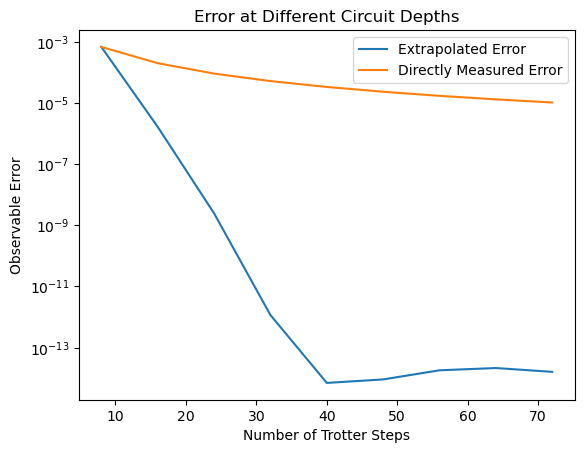

In [135]:
## Here we see how the error changes with the number of interpolating nodes/the degree of the approximating polynomial.

trot_order      = 2
time            = 1
s_min           = 1/min_step_no
max_node_number = 10

points_array = []
estimated_value_list = []
degree_array = []
error_array = []
best_data_val_array = []
best_val_error_array = []


# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)


        
# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1, max_node_number):
    
    order = k
    approximation = richardson_estimate(order, s_min, Hterms, initial_state, time, local_obs, trotter_order =2)
    
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list.append( approximation )
    degree_array.append( k )
    # Calculate the error relative to the exact value.
    error_array.append( np.abs( exact_val - estimated_value_list[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    # This is essentially calculating the best measurement error.
    
    # Generate a list of points to be sampled from.
    for m in range(1, max_node_number):
        counter = m
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
    
    # Now find the minimum on that list, and check the error associated with measuring the observable there.
    min_value_points_array = min(np.abs(points_array) )
    best_data_val_array.append( Trotterized_Expectation(Hterms, initial_state, time, min_value_points_array, local_obs, order = trot_order)  )
    best_val_error_array.append( np.abs( exact_val - best_data_val_array[k-1] )  )

    
    
# Convert array into the circuit depth in terms of elementary exponentials.

circuit_depth_array = min_step_number(nqubits, hlist, time)*(1/2)*np.array( degree_array )


# Plot graphs.

plt.semilogy(circuit_depth_array, error_array,  label="Extrapolated Error")
plt.semilogy(circuit_depth_array, best_val_error_array, label="Directly Measured Error"  )
plt.xlabel('Number of Trotter Steps')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Error at Different Circuit Depths")

In [136]:
### Export data to Excel for future use:

import pandas as pd
from datetime import datetime
from datetime import date

# Make string out of state description.
initial_state_string = ''
initial_state_string = [initial_state_string + str(k) for k in sparse_bitstring([nqubits//2], nqubits)]
initial_state_string = ''.join(initial_state_string)

# Initialise arrays.
List_Params = [None] * len(circuit_depth_array)
Params_Values = [None] * len(circuit_depth_array)
hlist_string = [None] * len(circuit_depth_array)
obs_string = [None] * len(circuit_depth_array)

# Put hlist in correctly formatted array.
for k in range(len(hlist)):
    hlist_string[k] = hlist[k]
    
# Put obs_string in correctly formatted array.    
for k in range(len(local_obs_array)):
    obs_string[k] = local_obs_array[k]

# Input the values of the parameters.    
List_Params[0] = 'Simulation Time'
List_Params[1] ='Trotter Order'
List_Params[2] = 'Number Qubits'
List_Params[3] ='Initial State String'
Params_Values[0] = time
Params_Values[1] = trot_order
Params_Values[2] = nqubits
Params_Values[3] = initial_state_string

# Print data:
data = {'Trotter_Depth': circuit_depth_array,
        'Extrapolated_Error': error_array, 
        'Direct_Measurement_Error': best_val_error_array,
        'hlist': hlist_string, 
        'Observable Strings': obs_string, 
        'List_of_Parameters': List_Params,
        'Parameter_Values': Params_Values,
        }

df = pd.DataFrame(data)

now = datetime.now()
current_time = now.strftime("%H.%M.%S")

file_location_name = r'Data_Sheets\A_Extrap_Error_vs_Measured_Error'+'_'+str(date.today())+'_'+current_time+'.xlsx'
df.to_excel(file_location_name, index=False)

# Extrapolation in the Presence of Measurements

Text(0.5, 1.0, 'Extrapolated vs. Regular Error in Presence of Noise')

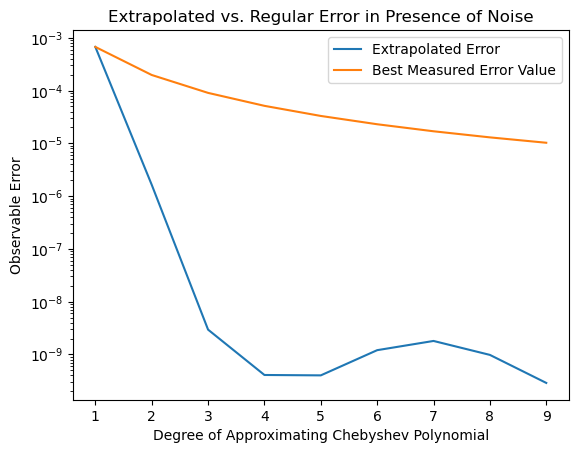

In [140]:
## In reality, the measurements are not perfect. Here we add some "noise" to the values we extrapolate through
## to determine how the extrapolation performs.

# Noise parameter; bounds the the maximum strength of the noise:
error_param = 10**(-9)

trot_order = 2
time = 1
s_min = 1/min_step_number(nqubits, hlist, time)
max_node_number = 10

points_array = []
estimated_value_list = []
degree_array = []
error_array = []
best_data_val_array = []
best_val_error_array = []



# Exact expectation value.
exact_val = Exact_Expectation(Htot, initial_state, time, local_obs)


        
# Generate a list of functions with increasing degree, then compute their estimate of the observable + error.
for k in range(1, max_node_number):
    
    order = k
    approximation = richardson_estimate_error(order, s_min, Hterms, initial_state, time, local_obs, error_param ,trotter_order =2)
    
    # Calculate the estimated value from the s=0 value of the interpolation
    estimated_value_list.append( approximation )
    degree_array.append( k )
    # Calculate the error relative to the exact value.
    error_array.append( np.abs( exact_val - estimated_value_list[k-1] )  )
    
    # Now compute error associated with the best value from data for each corresponding degree approximation.
    # This is essentially calculating the best measurement error.
    
    # Generate a list of points to be sampled from.
    for m in range(1, max_node_number):
        counter = m
        sample_point = s_min*( np.sin(np.pi*(2*counter-1)/(4*order)) )
        points_array.append( sample_point  )
    
    # Now find the minimum on that list, and check the error associated with measuring the observable there.
    min_value_points_array = min(np.abs(points_array) )
    best_data_val_array.append( Trotterized_Expectation(Hterms, initial_state, time, min_value_points_array, local_obs, order = trot_order)  )
    best_val_error_array.append( np.abs( exact_val - best_data_val_array[k-1] )  )

    
    
# Convert array into the circuit depth in terms of elementary exponentials.

circuit_depth_array = min_step_number(nqubits, hlist, time)*(1/2)*np.array( degree_array )

    
# Plot graphs.

plt.semilogy(degree_array, error_array,  label="Extrapolated Error")
plt.semilogy(degree_array , best_val_error_array, label="Best Measured Error Value"  )
plt.xlabel('Order of Richardson Approximation')
plt.ylabel('Observable Error')
plt.legend()
plt.title("Extrapolated vs. Regular Error in Presence of Noise")